In [48]:
import sys
from commonfunctions import *
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from skimage.color import rgb2gray
from scipy.ndimage import interpolation as inter
from skimage.morphology import binary_erosion, binary_dilation

import cv2
from utlis import *

In [49]:
def skew_correction(image, showTrace = False):
        
    # correct skew
    def RotationAngle(binImg):
        def find_score(arr, angle):
            data = inter.rotate(arr, angle, reshape=False, order=0)
            hist = np.sum(data, axis=1)
            score = np.sum((hist[1:] - hist[:-1]) ** 2)
            return hist, score
        delta = 1
        limit = 50
        angles = np.arange(-limit, limit+delta, delta)
        scores = []
        for angle in angles:
            hist, score = find_score(binImg, angle)
            scores.append(score)
        best_score = max(scores)
        best_angle = angles[scores.index(best_score)]
        return best_angle

    def RotateImage(thresh2,angle):
        (h, w) = thresh2.shape
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        rotated_image = cv2.warpAffine(img, M, (w, h),borderMode=cv2.BORDER_CONSTANT,borderValue=(255,255,255))
        return rotated_image

    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 199, 5)
    rotated = RotateImage(thresh2,RotationAngle(thresh2))
    if(showTrace):
        show_images([rotated])
    
    return rotated

In [50]:
def trepozoidal_correction(image, showTrace = False):
    img = cv2.resize(image, (int(480*2), int(640*2)))

    w, h = 480, 640
    imgWarp = img.copy()
    
    GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    BlurredFrame = cv2.GaussianBlur(GrayImg, (5, 5), 1)

    CannyFrame = cv2.Canny(BlurredFrame, 70, 70)


    contours, _ = cv2.findContours(CannyFrame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ContourFrame = img.copy()
    ContourFrame = cv2.drawContours(ContourFrame, contours, -1, (255, 0, 255), 4)

    CornerFrame = img.copy()

    maxArea = 0
    biggest = []
    biggest, maxArea = biggestContour(contours)

    if len(biggest) != 0 :
        biggest = reorder(biggest)
        drawRectangle(CornerFrame, biggest, 20)
        CornerFrame = cv2.drawContours(CornerFrame, biggest, -1, (255, 0, 255), 25)
        pts1 = np.float32(biggest)
        pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        imgWarpColored = cv2.warpPerspective(img, matrix, (w, h))

        imgWarp = imgWarpColored.copy()
        imgWarp=imgWarp[20:imgWarp.shape[0]+20, 20:imgWarp.shape[1]+20]
        imgWarp = cv2.resize(imgWarp,(w, h))

    # resizing
    img = cv2.resize(img, (480, 640))
    GrayImg = cv2.resize(GrayImg, (480, 640))
    BlurredFrame = cv2.resize(BlurredFrame, (480, 640))
    CannyFrame = cv2.resize(CannyFrame, (480, 640))
    ContourFrame = cv2.resize(ContourFrame, (480, 640))
    CornerFrame = cv2.resize(CornerFrame, (480, 640))

    #displaying
    if(showTrace):
        show_images([img,GrayImg,BlurredFrame,CannyFrame,ContourFrame])  
        show_images([CornerFrame,imgWarpColored,imgWarp])  
    return imgWarp

In [ ]:
#initializing

img = cv2.imread("preprocessing_imgs/hand.jpg")

def preprocessing (img, showTrace = False):
    # img = cv2.resize(image, (480*2, 640*2))
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgThre= cv2.adaptiveThreshold(imgGray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
       cv2.THRESH_BINARY_INV, 1001, 5)

    imgThre2 = cv2.bitwise_not(imgThre)
    imgThre3 =cv2.medianBlur(imgThre2,3)
    w, h = imgThre3.shape
    # ErodedImg = binary_dilation(binary_erosion(imgAdaptiveThre))
    if(showTrace):
        show_images([imgGray,imgThre,imgThre2,imgThre3]) 

    top = np.sum(imgThre3[0:20, 0:h])/(20*h)
    bottom = np.sum(imgThre3[w-20:w, 0:h])/(20*h)
    right = np.sum(imgThre3[0:w, 0:20])/(20*w)
    left = np.sum(imgThre3[0:w, h-20:h])/(20*w)
    check = (top+bottom+right+left)/4
    if(check<100):
        img = trepozoidal_correction(img)
        print('trapezoidal')
    else:
        img = skew_correction(img)
        print('skew')
  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgThre= cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
       cv2.THRESH_BINARY, 11, 5)
    # _,imgThre = cv2.adaptiveThreshold(img,50,255,cv2.THRESH_BINARY)
    return imgThre

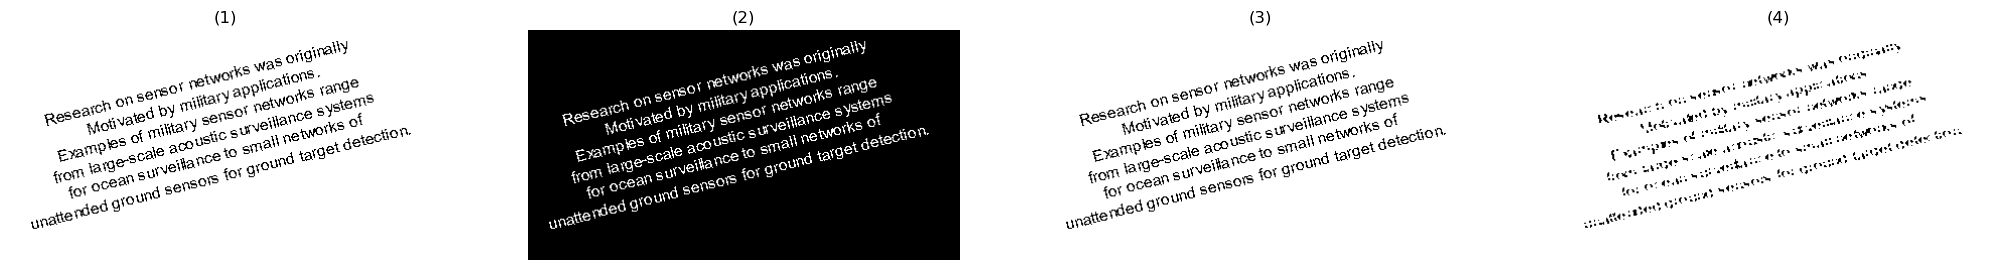

C:\Users\77\AppData\Local\Temp\ipykernel_25816\3192726344.py:6: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


skew


error: OpenCV(4.5.4) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x694991f6::Set<1,-1,-1>,struct cv::impl::A0x694991f6::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [82]:
io.imshow(preprocessing(img, showTrace=True))